In [1]:
import time
import os

In [2]:
from io import StringIO

In [3]:
import skops.io as sio

In [4]:
from bs4 import BeautifulSoup
import requests

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [6]:
import seaborn as sns

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, PassiveAggressiveRegressor
from sklearn import metrics

In [8]:
from sklearn.preprocessing import normalize

In [9]:
from xgboost import XGBRegressor

In [10]:
pd.options.display.max_columns = None

In [13]:
# Takes in year and returns the last 2 digits that represent its year
# Examples:
# 2013 -> '13'
# 1999 -> '99'
# 2001 -> '01'
def get_last_year_digits(year):
    return str(year)[-2:]

In [14]:
# Takes in a DataFrame for regular season statistics of the Four Factors and normalizes it (using sklearn)
calc_cols = ['eFG%', 'FTARate', 'TOV%', 'OREB%', 'OppeFG%', 'OppFTARate', 'OppTOV%', 'OppDREB%']
rel_cols = ['Rel' + col for col in calc_cols]
def add_rel_cols(df):
    for col in calc_cols:
        new_col = 'Rel' + col
        df[new_col] = normalize([df[col]])[0]

In [15]:
# Create the csv folder if it's not there
if (not os.path.isdir('csv')):
    os.mkdir('csv')

## Preparing Data

In [48]:
start_year, end_year = 1984, 2024

### Regular Season

In [16]:
if (not os.path.isdir('csv/regseason')):
    os.mkdir('csv/regseason')

In [17]:
# Get URL from Basketball Reference based on year
get_basketball_reference_url = lambda x: f'https://www.basketball-reference.com/leagues/NBA_{x}.html'

In [49]:
for year in range(start_year, end_year):
    url = get_basketball_reference_url(year)
    season_year_end = get_last_year_digits(year)
    season_year_start = get_last_year_digits(year - 1)
    
    reg_season = requests.get(url)
    soup = BeautifulSoup(reg_season.content)
    advanced = soup.find(id='advanced-team') # Grabs the table I want

    df = pd.read_html(StringIO(advanced.prettify()))[0] # Found this nifty little function that I should've used before
    
    # Cleans up the MultiIndex that the DataFrame is created with
    top_unnamed = [f'Unnamed: {x}_level_0' for x in range(len(df.columns))] 
    col_clean = dict.fromkeys(top_unnamed, '')
    col_clean['Offense Four Factors'] = ''
    col_clean['Defense Four Factors'] = 'Opp'
    
    df = df.rename(columns=col_clean).drop(columns=[('', 'Unnamed: 17_level_1'), ('', 'Unnamed: 22_level_1'), ('', 'Unnamed: 27_level_1')])
    df.columns = [''.join(col) for col in df.columns]
    
    # Renames FT/FGA to FTARate and RB to REB to not have to change old code
    df = df.rename(columns={'FT/FGA': 'FTARate', 'OppFT/FGA': 'OppFTARate', 'ORB%': 'OREB%', 'OppDRB%': 'OppDREB%' })
    
    # Removes "League Average" row
    df = df[df['Rk'] == df['Rk']]
    
    # Cleans up decimals where they don't need to be
    df = df.astype({'Rk': int, 'W': int, 'L': int})
    
    # Removes whether a team made the playoffs
    df['Made Playoffs'] = df['Team'].str.endswith('*')
    df['Team'] = df['Team'].str.removesuffix('*')
    df['Team'] = df['Team'].str.rstrip()
    
    # Outputs to CSV file
    csv_output = f'csv/regseason/{season_year_start}_{season_year_end}.csv'
    df.to_csv(csv_output)
    print(f'Wrote to {csv_output}.')
    
    # Tries not to trigger Basketball Reference's rate limiter
    time.sleep(5)

Wrote to csv/regseason/83_84.csv.
Wrote to csv/regseason/84_85.csv.
Wrote to csv/regseason/85_86.csv.
Wrote to csv/regseason/86_87.csv.
Wrote to csv/regseason/87_88.csv.
Wrote to csv/regseason/88_89.csv.
Wrote to csv/regseason/89_90.csv.
Wrote to csv/regseason/90_91.csv.
Wrote to csv/regseason/91_92.csv.
Wrote to csv/regseason/92_93.csv.
Wrote to csv/regseason/93_94.csv.
Wrote to csv/regseason/94_95.csv.
Wrote to csv/regseason/95_96.csv.
Wrote to csv/regseason/96_97.csv.
Wrote to csv/regseason/97_98.csv.
Wrote to csv/regseason/98_99.csv.
Wrote to csv/regseason/99_00.csv.
Wrote to csv/regseason/00_01.csv.
Wrote to csv/regseason/01_02.csv.
Wrote to csv/regseason/02_03.csv.
Wrote to csv/regseason/03_04.csv.
Wrote to csv/regseason/04_05.csv.
Wrote to csv/regseason/05_06.csv.
Wrote to csv/regseason/06_07.csv.
Wrote to csv/regseason/07_08.csv.
Wrote to csv/regseason/08_09.csv.
Wrote to csv/regseason/09_10.csv.
Wrote to csv/regseason/10_11.csv.
Wrote to csv/regseason/11_12.csv.
Wrote to csv/r

#### Graphing Relative Data

In [53]:
graph_data = f'csv/regseason/{get_last_year_digits(end_year - 2)}_{get_last_year_digits(end_year - 1)}.csv'

In [54]:
graph_data

'csv/regseason/22_23.csv'

In [55]:
table = pd.read_csv(graph_data)

In [56]:
add_rel_cols(table)

In [57]:
xpoints = list(range(1, 31))
xpoints.reverse()
# Generating x-values for rankings

In [58]:
# Offensive Rankings
efg_points = table['eFG%'].sort_values(ascending = True)
tov_points = table['TOV%'].sort_values(ascending = False)
# The best teams turn the ball over less, so you reverse this one for a more accurate view at who is good at mitigating TOs.
fta_points = table['FTARate'].sort_values(ascending = True)
oreb_points = table['OREB%'].sort_values(ascending = True)

[Text(0.5, 0, 'League Rank')]

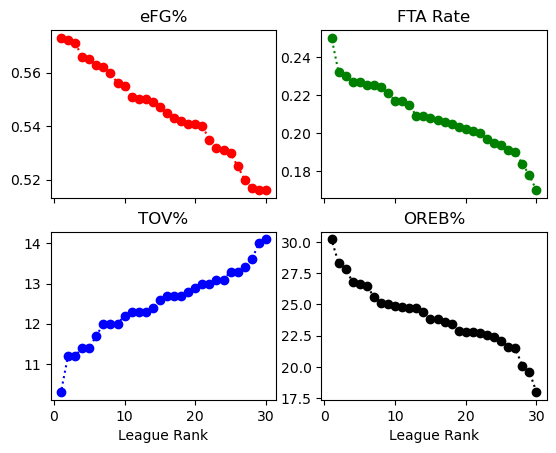

In [59]:
fig, ax = plt.subplots(2, 2)

efg_plt = ax[0, 0]
efg_plt.plot(xpoints, efg_points, 'o:r')
efg_plt.set_xticklabels([])
efg_plt.set_title('eFG%')

tov_plt = ax[1, 0]
tov_plt.plot(xpoints, tov_points, 'o:b')
tov_plt.set_title('TOV%')
tov_plt.set(xlabel='League Rank')

fta_plt = ax[0, 1]
fta_plt.plot(xpoints, fta_points, 'o:g')
fta_plt.set_xticklabels([])
fta_plt.set_title('FTA Rate')

oreb_plt = ax[1, 1]
oreb_plt.plot(xpoints, oreb_points, 'o:k')
oreb_plt.set_title('OREB%')
oreb_plt.set(xlabel='League Rank')

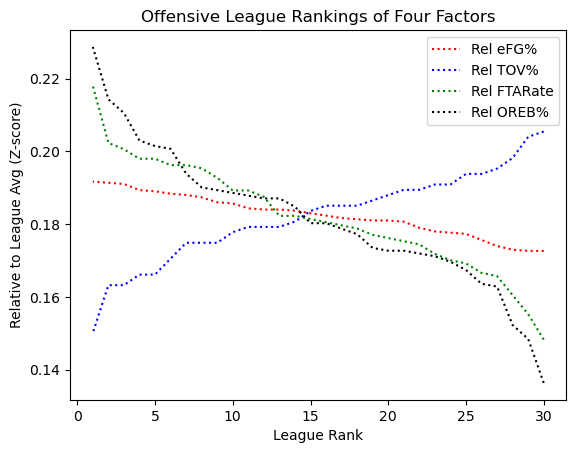

In [60]:
# red = eFG%
# blue = TOV%
# green = FTA Rate
# black = OREB%
rel_efg_points = table['ReleFG%'].sort_values(ascending = True)
rel_tov_points = table['RelTOV%'].sort_values(ascending = False)
# Multiplying the z-score by -1 so that the teams w/ the greatest TOV% have the worse z-score
rel_fta_points = table['RelFTARate'].sort_values(ascending = True)
rel_oreb_points = table['RelOREB%'].sort_values(ascending = True)
plt.plot(xpoints, rel_efg_points, ':r', label = 'Rel eFG%')
plt.plot(xpoints, rel_tov_points, ':b', label = 'Rel TOV%')
plt.plot(xpoints, rel_fta_points, ':g', label = 'Rel FTARate')
plt.plot(xpoints, rel_oreb_points, ':k', label = 'Rel OREB%')
plt.title('Offensive League Rankings of Four Factors')
plt.xlabel('League Rank')
plt.ylabel('Relative to League Avg (Z-score)')
plt.legend()
plt.show()

In [61]:
opp_efg_points = table['OppeFG%'].sort_values(ascending = False)
opp_tov_points = table['OppTOV%'].sort_values(ascending = True)
opp_fta_points = table['OppFTARate'].sort_values(ascending = False)
opp_dreb_points = table['OppDREB%'].sort_values(ascending = False)

[Text(0.5, 0, 'League Rank')]

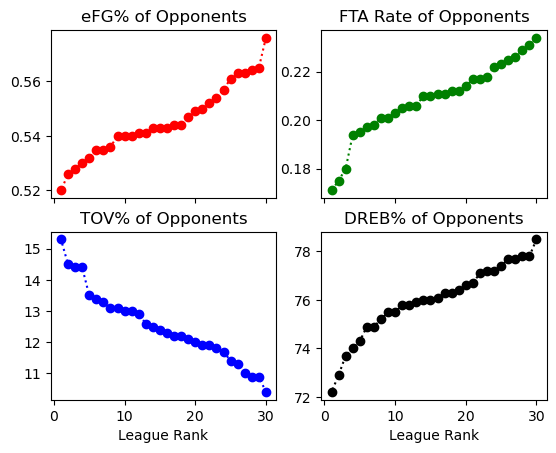

In [62]:
# Defensive Rankings
fig, ax = plt.subplots(2, 2)

efg_plt = ax[0, 0]
efg_plt.plot(xpoints, opp_efg_points, 'o:r')
efg_plt.set_xticklabels([])
efg_plt.set_title('eFG% of Opponents')

tov_plt = ax[1, 0]
tov_plt.plot(xpoints, opp_tov_points, 'o:b')
tov_plt.set_title('TOV% of Opponents')
tov_plt.set(xlabel='League Rank')

fta_plt = ax[0, 1]
fta_plt.plot(xpoints, opp_fta_points, 'o:g')
fta_plt.set_xticklabels([])
fta_plt.set_title('FTA Rate of Opponents')

oreb_plt = ax[1, 1]
oreb_plt.plot(xpoints, opp_dreb_points, 'o:k')
oreb_plt.set_title('DREB% of Opponents')
oreb_plt.set(xlabel='League Rank')

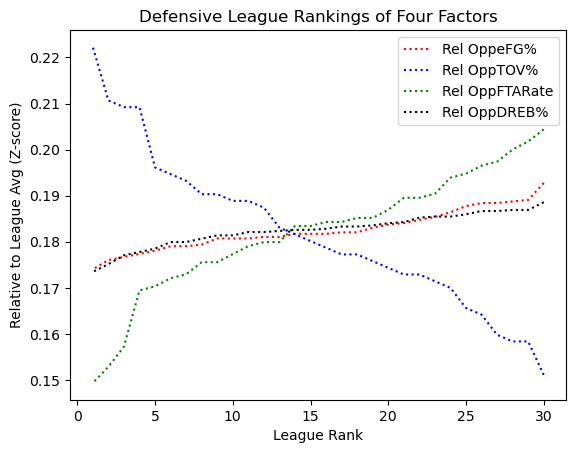

In [63]:
rel_opp_efg_points = table['RelOppeFG%'].sort_values(ascending = False)
rel_opp_fta_points = table['RelOppFTARate'].sort_values(ascending = False)
rel_opp_tov_points = table['RelOppTOV%'].sort_values(ascending = True)
rel_opp_dreb_points = table['RelOppDREB%'].sort_values(ascending = False)

plt.plot(xpoints, rel_opp_efg_points, ':r', label = 'Rel OppeFG%')
plt.plot(xpoints, rel_opp_tov_points, ':b', label = 'Rel OppTOV%')
plt.plot(xpoints, rel_opp_fta_points, ':g', label = 'Rel OppFTARate')
plt.plot(xpoints, rel_opp_dreb_points, ':k', label = 'Rel OppDREB%')

plt.title('Defensive League Rankings of Four Factors')
plt.xlabel('League Rank')
plt.ylabel('Relative to League Avg (Z-score)')
plt.legend()
plt.show()

### Playoffs

In [64]:
if (not os.path.isdir('csv/playoffs')):
    os.mkdir('csv/playoffs')

In [65]:
get_basketball_reference_url_playoffs = lambda x: f'https://www.basketball-reference.com/playoffs/NBA_{x}.html#advanced-team'

In [67]:
for year in range(start_year, end_year):
    url = get_basketball_reference_url_playoffs(year)
    season_year_end = get_last_year_digits(year)
    season_year_start = get_last_year_digits(year - 1)
    
    playoffs = requests.get(url)
    psoup = BeautifulSoup(playoffs.content)
    ptable = psoup.find(id='advanced-team')
    
    pdf = pd.read_html(StringIO(ptable.prettify()))[0]
    
    top_unnamed = [f'Unnamed: {x}_level_0' for x in range(len(pdf.columns))] 
    col_clean = dict.fromkeys(top_unnamed, '')
    col_clean['Offense Four Factors'] = ''
    col_clean['Defense Four Factors'] = 'Opp'
    
    pdf = pdf.rename(columns=col_clean).drop(columns=[('', 'Unnamed: 15_level_1'), ('', 'Unnamed: 20_level_1')])
    pdf.columns = [''.join(col) for col in pdf.columns]
    
    pdf = pdf[pdf['Rk'] == pdf['Rk']]
    pdf = pdf.astype({ 'Rk': int, 'W': int, 'L': int })
    
    pdf = pdf.rename(columns={'Tm': 'Team'})
    
    # Outputs to CSV file
    csv_output = f'csv/playoffs/{season_year_start}_{season_year_end}.csv'
    pdf.to_csv(csv_output)
    print(f'Wrote to {csv_output}.')
    
    # Tries not to trigger Basketball Reference's rate limiter
    time.sleep(3)

Wrote to csv/playoffs/83_84.csv.
Wrote to csv/playoffs/84_85.csv.
Wrote to csv/playoffs/85_86.csv.
Wrote to csv/playoffs/86_87.csv.
Wrote to csv/playoffs/87_88.csv.
Wrote to csv/playoffs/88_89.csv.
Wrote to csv/playoffs/89_90.csv.
Wrote to csv/playoffs/90_91.csv.
Wrote to csv/playoffs/91_92.csv.
Wrote to csv/playoffs/92_93.csv.
Wrote to csv/playoffs/93_94.csv.
Wrote to csv/playoffs/94_95.csv.
Wrote to csv/playoffs/95_96.csv.
Wrote to csv/playoffs/96_97.csv.
Wrote to csv/playoffs/97_98.csv.
Wrote to csv/playoffs/98_99.csv.
Wrote to csv/playoffs/99_00.csv.
Wrote to csv/playoffs/00_01.csv.
Wrote to csv/playoffs/01_02.csv.
Wrote to csv/playoffs/02_03.csv.
Wrote to csv/playoffs/03_04.csv.
Wrote to csv/playoffs/04_05.csv.
Wrote to csv/playoffs/05_06.csv.
Wrote to csv/playoffs/06_07.csv.
Wrote to csv/playoffs/07_08.csv.
Wrote to csv/playoffs/08_09.csv.
Wrote to csv/playoffs/09_10.csv.
Wrote to csv/playoffs/10_11.csv.
Wrote to csv/playoffs/11_12.csv.
Wrote to csv/playoffs/12_13.csv.
Wrote to c

## Test Merges

In [83]:
reg_file = f'csv/regseason/{get_last_year_digits(end_year - 2)}_{get_last_year_digits(end_year - 1)}.csv'
playoff_file = f'csv/playoffs/{get_last_year_digits(end_year - 2)}_{get_last_year_digits(end_year - 1)}.csv'

In [92]:
reg = pd.read_csv(reg_file, index_col=0)
playoffs = pd.read_csv(playoff_file)

In [93]:
playoffs_wins = playoffs[['Team', 'W', 'L', 'W/L%']]
playoffs_wins = playoffs_wins.rename(columns={'W': 'PlayoffW', 'L': 'PlayoffL', 'W/L%': 'PlayoffWIN%'})
playoffs_wins['PlayoffGP'] = playoffs_wins['PlayoffW'] + playoffs_wins['PlayoffL']
playoffs_wins = playoffs_wins[playoffs_wins['PlayoffGP'] > 0]

In [94]:
playoffs_wins

,Team,PlayoffW,PlayoffL,PlayoffWIN%,PlayoffGP
0,Denver Nuggets,16,4,0.800,20
1,Boston Celtics,11,9,0.550,20
2,Los Angeles Lakers,8,8,0.500,16
3,Miami Heat,13,10,0.565,23
4,New York Knicks,6,5,0.545,11
5,Golden State Warriors,6,7,0.462,13
6,Philadelphia 76ers,7,4,0.636,11
7,Sacramento Kings,3,4,0.429,7
8,Phoenix Suns,6,5,0.545,11
9,Milwaukee Bucks,1,4,0.200,5


In [95]:
add_rel_cols(reg)

In [97]:
reg.head()

,Rk,Team,Age,W,L,PW,PL,MOV,SOS,SRS,ORtg,DRtg,NRtg,Pace,FTr,3PAr,TS%,eFG%,TOV%,OREB%,FTARate,OppeFG%,OppTOV%,OppDREB%,OppFTARate,Arena,Attend.,Attend./G,Made Playoffs,ReleFG%,RelFTARate,RelTOV%,RelOREB%,RelOppeFG%,RelOppFTARate,RelOppTOV%,RelOppDREB%
0,1,Boston Celtics,27.4,57,25,57,25,6.52,-0.15,6.38,118.0,111.5,6.5,98.5,0.243,0.480,0.600,0.566,12.0,22.1,0.197,0.528,11.3,78.5,0.180,TD Garden,766240,18689,True,0.189357,0.171806,0.174862,0.167379,0.176700,0.157222,0.164177,0.188594
1,2,Cleveland Cavaliers,25.4,51,31,55,27,5.38,-0.15,5.23,116.1,110.6,5.5,95.7,0.264,0.371,0.590,0.556,12.3,23.6,0.206,0.535,14.4,76.3,0.210,Rocket Mortgage Fieldhouse,777280,18958,True,0.186012,0.179655,0.179234,0.178739,0.179042,0.183425,0.209217,0.183308
2,3,Philadelphia 76ers,28.2,54,28,52,30,4.32,0.06,4.37,117.7,113.3,4.4,96.9,0.300,0.389,0.608,0.563,12.6,21.6,0.250,0.541,13.0,77.2,0.217,Wells Fargo Center,839261,20470,True,0.188354,0.218028,0.183605,0.163592,0.181050,0.189540,0.188876,0.185471
3,4,Memphis Grizzlies,24.4,51,31,51,31,3.94,-0.34,3.60,115.1,111.2,3.9,101.1,0.259,0.372,0.570,0.540,11.7,26.5,0.190,0.526,13.1,75.9,0.206,FedEx Forum,707836,17264,True,0.180659,0.165701,0.170491,0.200703,0.176031,0.179932,0.190329,0.182347
4,5,Milwaukee Bucks,29.8,58,24,50,32,3.63,-0.02,3.61,115.4,111.9,3.5,100.5,0.248,0.446,0.583,0.555,12.7,25.0,0.184,0.520,10.4,77.8,0.175,Fiserv Forum,718786,17531,True,0.185677,0.160468,0.185062,0.189342,0.174023,0.152855,0.151101,0.186912


### Only Playoff Teams

#### Merging Datasets

In [98]:
merge2 = reg.merge(playoffs_wins, how='inner', left_on = 'Team', right_on = 'Team')
# Inner Join excludes all teams that didn't make the playoffs
merge2 = merge2.fillna(0)
# Fill in the NaN's so that we can do math with the non-playoff teams
merge2

,Rk,Team,Age,W,L,PW,PL,MOV,SOS,SRS,ORtg,DRtg,NRtg,Pace,FTr,3PAr,TS%,eFG%,TOV%,OREB%,FTARate,OppeFG%,OppTOV%,OppDREB%,OppFTARate,Arena,Attend.,Attend./G,Made Playoffs,ReleFG%,RelFTARate,RelTOV%,RelOREB%,RelOppeFG%,RelOppFTARate,RelOppTOV%,RelOppDREB%,PlayoffW,PlayoffL,PlayoffWIN%,PlayoffGP
0,1,Boston Celtics,27.4,57,25,57,25,6.52,-0.15,6.38,118.0,111.5,6.5,98.5,0.243,0.480,0.600,0.566,12.0,22.1,0.197,0.528,11.3,78.5,0.180,TD Garden,766240,18689,True,0.189357,0.171806,0.174862,0.167379,0.176700,0.157222,0.164177,0.188594,11,9,0.550,20
1,2,Cleveland Cavaliers,25.4,51,31,55,27,5.38,-0.15,5.23,116.1,110.6,5.5,95.7,0.264,0.371,0.590,0.556,12.3,23.6,0.206,0.535,14.4,76.3,0.210,Rocket Mortgage Fieldhouse,777280,18958,True,0.186012,0.179655,0.179234,0.178739,0.179042,0.183425,0.209217,0.183308,1,4,0.200,5
2,3,Philadelphia 76ers,28.2,54,28,52,30,4.32,0.06,4.37,117.7,113.3,4.4,96.9,0.300,0.389,0.608,0.563,12.6,21.6,0.250,0.541,13.0,77.2,0.217,Wells Fargo Center,839261,20470,True,0.188354,0.218028,0.183605,0.163592,0.181050,0.189540,0.188876,0.185471,7,4,0.636,11
3,4,Memphis Grizzlies,24.4,51,31,51,31,3.94,-0.34,3.60,115.1,111.2,3.9,101.1,0.259,0.372,0.570,0.540,11.7,26.5,0.190,0.526,13.1,75.9,0.206,FedEx Forum,707836,17264,True,0.180659,0.165701,0.170491,0.200703,0.176031,0.179932,0.190329,0.182347,2,4,0.333,6
4,5,Milwaukee Bucks,29.8,58,24,50,32,3.63,-0.02,3.61,115.4,111.9,3.5,100.5,0.248,0.446,0.583,0.555,12.7,25.0,0.184,0.520,10.4,77.8,0.175,Fiserv Forum,718786,17531,True,0.185677,0.160468,0.185062,0.189342,0.174023,0.152855,0.151101,0.186912,1,4,0.200,5
5,6,Denver Nuggets,26.6,53,29,49,33,3.33,-0.29,3.04,117.6,114.2,3.4,98.1,0.259,0.361,0.601,0.573,13.1,24.8,0.194,0.543,12.2,76.4,0.201,Ball Arena,788635,19235,True,0.191699,0.169189,0.190891,0.187828,0.181720,0.175564,0.177253,0.183549,16,4,0.800,20
6,7,New York Knicks,24.5,47,35,48,34,2.93,0.06,2.99,117.8,114.8,3.0,97.1,0.285,0.400,0.577,0.541,11.4,28.3,0.217,0.536,11.4,77.1,0.210,Madison Square Garden (IV),795110,19393,True,0.180994,0.189248,0.166119,0.214336,0.179377,0.183425,0.165630,0.185230,6,5,0.545,11
7,8,Sacramento Kings,25.4,48,34,47,35,2.65,-0.35,2.30,119.4,116.8,2.6,100.3,0.284,0.423,0.608,0.572,12.0,22.7,0.225,0.563,12.6,77.2,0.203,Golden 1 Center,715491,17451,True,0.191365,0.196225,0.174862,0.171923,0.188413,0.177311,0.183065,0.185471,3,4,0.429,7
8,9,Phoenix Suns,28.1,45,37,46,36,2.07,0.01,2.08,115.1,113.0,2.1,98.2,0.241,0.362,0.570,0.535,12.0,26.6,0.191,0.532,12.9,76.0,0.234,Footprint Center,699911,17071,True,0.178986,0.166573,0.174862,0.201460,0.178039,0.204388,0.187423,0.182588,6,5,0.545,11
9,11,Golden State Warriors,27.3,44,38,45,37,1.80,-0.15,1.66,116.1,114.4,1.7,101.6,0.224,0.479,0.600,0.571,14.1,24.4,0.178,0.540,12.3,76.0,0.214,Chase Center,740624,18064,True,0.191030,0.155236,0.205463,0.184798,0.180716,0.186919,0.178706,0.182588,6,7,0.462,13


In [99]:
merge2['Champ%'] = merge2['PlayoffW'] / merge2['PlayoffW'].max()
merge2['PlayoffGP'] = merge2['PlayoffGP'].astype('int64')
merge2['PlayoffW'] = merge2['PlayoffW'].astype('int64')
merge2['PlayoffL'] = merge2['PlayoffL'].astype('int64')

In [100]:
merge2

,Rk,Team,Age,W,L,PW,PL,MOV,SOS,SRS,ORtg,DRtg,NRtg,Pace,FTr,3PAr,TS%,eFG%,TOV%,OREB%,FTARate,OppeFG%,OppTOV%,OppDREB%,OppFTARate,Arena,Attend.,Attend./G,Made Playoffs,ReleFG%,RelFTARate,RelTOV%,RelOREB%,RelOppeFG%,RelOppFTARate,RelOppTOV%,RelOppDREB%,PlayoffW,PlayoffL,PlayoffWIN%,PlayoffGP,Champ%
0,1,Boston Celtics,27.4,57,25,57,25,6.52,-0.15,6.38,118.0,111.5,6.5,98.5,0.243,0.480,0.600,0.566,12.0,22.1,0.197,0.528,11.3,78.5,0.180,TD Garden,766240,18689,True,0.189357,0.171806,0.174862,0.167379,0.176700,0.157222,0.164177,0.188594,11,9,0.550,20,0.6875
1,2,Cleveland Cavaliers,25.4,51,31,55,27,5.38,-0.15,5.23,116.1,110.6,5.5,95.7,0.264,0.371,0.590,0.556,12.3,23.6,0.206,0.535,14.4,76.3,0.210,Rocket Mortgage Fieldhouse,777280,18958,True,0.186012,0.179655,0.179234,0.178739,0.179042,0.183425,0.209217,0.183308,1,4,0.200,5,0.0625
2,3,Philadelphia 76ers,28.2,54,28,52,30,4.32,0.06,4.37,117.7,113.3,4.4,96.9,0.300,0.389,0.608,0.563,12.6,21.6,0.250,0.541,13.0,77.2,0.217,Wells Fargo Center,839261,20470,True,0.188354,0.218028,0.183605,0.163592,0.181050,0.189540,0.188876,0.185471,7,4,0.636,11,0.4375
3,4,Memphis Grizzlies,24.4,51,31,51,31,3.94,-0.34,3.60,115.1,111.2,3.9,101.1,0.259,0.372,0.570,0.540,11.7,26.5,0.190,0.526,13.1,75.9,0.206,FedEx Forum,707836,17264,True,0.180659,0.165701,0.170491,0.200703,0.176031,0.179932,0.190329,0.182347,2,4,0.333,6,0.1250
4,5,Milwaukee Bucks,29.8,58,24,50,32,3.63,-0.02,3.61,115.4,111.9,3.5,100.5,0.248,0.446,0.583,0.555,12.7,25.0,0.184,0.520,10.4,77.8,0.175,Fiserv Forum,718786,17531,True,0.185677,0.160468,0.185062,0.189342,0.174023,0.152855,0.151101,0.186912,1,4,0.200,5,0.0625
5,6,Denver Nuggets,26.6,53,29,49,33,3.33,-0.29,3.04,117.6,114.2,3.4,98.1,0.259,0.361,0.601,0.573,13.1,24.8,0.194,0.543,12.2,76.4,0.201,Ball Arena,788635,19235,True,0.191699,0.169189,0.190891,0.187828,0.181720,0.175564,0.177253,0.183549,16,4,0.800,20,1.0000
6,7,New York Knicks,24.5,47,35,48,34,2.93,0.06,2.99,117.8,114.8,3.0,97.1,0.285,0.400,0.577,0.541,11.4,28.3,0.217,0.536,11.4,77.1,0.210,Madison Square Garden (IV),795110,19393,True,0.180994,0.189248,0.166119,0.214336,0.179377,0.183425,0.165630,0.185230,6,5,0.545,11,0.3750
7,8,Sacramento Kings,25.4,48,34,47,35,2.65,-0.35,2.30,119.4,116.8,2.6,100.3,0.284,0.423,0.608,0.572,12.0,22.7,0.225,0.563,12.6,77.2,0.203,Golden 1 Center,715491,17451,True,0.191365,0.196225,0.174862,0.171923,0.188413,0.177311,0.183065,0.185471,3,4,0.429,7,0.1875
8,9,Phoenix Suns,28.1,45,37,46,36,2.07,0.01,2.08,115.1,113.0,2.1,98.2,0.241,0.362,0.570,0.535,12.0,26.6,0.191,0.532,12.9,76.0,0.234,Footprint Center,699911,17071,True,0.178986,0.166573,0.174862,0.201460,0.178039,0.204388,0.187423,0.182588,6,5,0.545,11,0.3750
9,11,Golden State Warriors,27.3,44,38,45,37,1.80,-0.15,1.66,116.1,114.4,1.7,101.6,0.224,0.479,0.600,0.571,14.1,24.4,0.178,0.540,12.3,76.0,0.214,Chase Center,740624,18064,True,0.191030,0.155236,0.205463,0.184798,0.180716,0.186919,0.178706,0.182588,6,7,0.462,13,0.3750


#### Creating Linear Model

In [102]:
inp, out = merge2[rel_cols], merge2['Champ%']

In [104]:
inp

,ReleFG%,RelFTARate,RelTOV%,RelOREB%,RelOppeFG%,RelOppFTARate,RelOppTOV%,RelOppDREB%
0,0.189357,0.171806,0.174862,0.167379,0.176700,0.157222,0.164177,0.188594
1,0.186012,0.179655,0.179234,0.178739,0.179042,0.183425,0.209217,0.183308
2,0.188354,0.218028,0.183605,0.163592,0.181050,0.189540,0.188876,0.185471
3,0.180659,0.165701,0.170491,0.200703,0.176031,0.179932,0.190329,0.182347
4,0.185677,0.160468,0.185062,0.189342,0.174023,0.152855,0.151101,0.186912
5,0.191699,0.169189,0.190891,0.187828,0.181720,0.175564,0.177253,0.183549
6,0.180994,0.189248,0.166119,0.214336,0.179377,0.183425,0.165630,0.185230
7,0.191365,0.196225,0.174862,0.171923,0.188413,0.177311,0.183065,0.185471
8,0.178986,0.166573,0.174862,0.201460,0.178039,0.204388,0.187423,0.182588
9,0.191030,0.155236,0.205463,0.184798,0.180716,0.186919,0.178706,0.182588


In [105]:
out

0     0.6875
1     0.0625
2     0.4375
3     0.1250
4     0.0625
5     1.0000
6     0.3750
7     0.1875
8     0.3750
9     0.3750
10    0.0000
11    0.5000
12    0.0625
13    0.1250
14    0.0625
15    0.8125
Name: Champ%, dtype: float64

In [106]:
x_train, x_test, y_train, y_test = train_test_split(inp, out, test_size=0.3)

In [107]:
small_lm1 = LinearRegression()
small_lm1.fit(x_train, y_train)

LinearRegression()

In [108]:
small_lm1.intercept_

-26.508563273089703

In [109]:
list(zip(rel_cols, small_lm1.coef_))

[('ReleFG%', 118.9588532546984),
 ('RelFTARate', 4.268681258412071),
 ('RelTOV%', -22.698218918906328),
 ('RelOREB%', 15.975482647592),
 ('RelOppeFG%', 91.37054473846366),
 ('RelOppFTARate', -31.792249282645123),
 ('RelOppTOV%', 18.62869832027887),
 ('RelOppDREB%', -47.720691341330216)]

In [110]:
y_pred_small_lm1 = small_lm1.predict(x_test)

In [111]:
pd.DataFrame({'Predicted': y_pred_small_lm1, 'Actual': y_test, 'Difference': y_pred_small_lm1 - y_test})

,Predicted,Actual,Difference
13,0.923708,0.1250,0.798708
1,0.850781,0.0625,0.788281
8,-0.708395,0.3750,-1.083395
5,1.250904,1.0000,0.250904
7,2.008820,0.1875,1.821320


In [112]:
mean_ab_err = metrics.mean_absolute_error(y_test, y_pred_small_lm1)
mean_sq_err = metrics.mean_squared_error(y_test, y_pred_small_lm1)
root_mean_sq_err = np.sqrt(metrics.mean_squared_error(y_test, y_pred_small_lm1))

print('R squared: {:.2f}'.format(small_lm1.score(inp,out)*100))
print('Mean Absolute Error:', mean_ab_err)
print('Mean Square Error:', mean_sq_err)
print('Root Mean Square Error:', root_mean_sq_err)

R squared: -337.26
Mean Absolute Error: 0.948521567238626
Mean Square Error: 1.1626452120948283
Root Mean Square Error: 1.078260271036093


### Including Every Team

In [113]:
merge = reg.merge(playoffs_wins, how='outer', left_on = 'Team', right_on = 'Team')
# Outer Join allows all teams to be included in the data set
merge = merge.fillna(0)
# Fill in the NaN's so that we can do math with the non-playoff teams
merge

,Rk,Team,Age,W,L,PW,PL,MOV,SOS,SRS,ORtg,DRtg,NRtg,Pace,FTr,3PAr,TS%,eFG%,TOV%,OREB%,FTARate,OppeFG%,OppTOV%,OppDREB%,OppFTARate,Arena,Attend.,Attend./G,Made Playoffs,ReleFG%,RelFTARate,RelTOV%,RelOREB%,RelOppeFG%,RelOppFTARate,RelOppTOV%,RelOppDREB%,PlayoffW,PlayoffL,PlayoffWIN%,PlayoffGP
0,1,Boston Celtics,27.4,57,25,57,25,6.52,-0.15,6.38,118.0,111.5,6.5,98.5,0.243,0.480,0.600,0.566,12.0,22.1,0.197,0.528,11.3,78.5,0.180,TD Garden,766240,18689,True,0.189357,0.171806,0.174862,0.167379,0.176700,0.157222,0.164177,0.188594,11.0,9.0,0.550,20.0
1,2,Cleveland Cavaliers,25.4,51,31,55,27,5.38,-0.15,5.23,116.1,110.6,5.5,95.7,0.264,0.371,0.590,0.556,12.3,23.6,0.206,0.535,14.4,76.3,0.210,Rocket Mortgage Fieldhouse,777280,18958,True,0.186012,0.179655,0.179234,0.178739,0.179042,0.183425,0.209217,0.183308,1.0,4.0,0.200,5.0
2,3,Philadelphia 76ers,28.2,54,28,52,30,4.32,0.06,4.37,117.7,113.3,4.4,96.9,0.300,0.389,0.608,0.563,12.6,21.6,0.250,0.541,13.0,77.2,0.217,Wells Fargo Center,839261,20470,True,0.188354,0.218028,0.183605,0.163592,0.181050,0.189540,0.188876,0.185471,7.0,4.0,0.636,11.0
3,4,Memphis Grizzlies,24.4,51,31,51,31,3.94,-0.34,3.60,115.1,111.2,3.9,101.1,0.259,0.372,0.570,0.540,11.7,26.5,0.190,0.526,13.1,75.9,0.206,FedEx Forum,707836,17264,True,0.180659,0.165701,0.170491,0.200703,0.176031,0.179932,0.190329,0.182347,2.0,4.0,0.333,6.0
4,5,Milwaukee Bucks,29.8,58,24,50,32,3.63,-0.02,3.61,115.4,111.9,3.5,100.5,0.248,0.446,0.583,0.555,12.7,25.0,0.184,0.520,10.4,77.8,0.175,Fiserv Forum,718786,17531,True,0.185677,0.160468,0.185062,0.189342,0.174023,0.152855,0.151101,0.186912,1.0,4.0,0.200,5.0
5,6,Denver Nuggets,26.6,53,29,49,33,3.33,-0.29,3.04,117.6,114.2,3.4,98.1,0.259,0.361,0.601,0.573,13.1,24.8,0.194,0.543,12.2,76.4,0.201,Ball Arena,788635,19235,True,0.191699,0.169189,0.190891,0.187828,0.181720,0.175564,0.177253,0.183549,16.0,4.0,0.800,20.0
6,7,New York Knicks,24.5,47,35,48,34,2.93,0.06,2.99,117.8,114.8,3.0,97.1,0.285,0.400,0.577,0.541,11.4,28.3,0.217,0.536,11.4,77.1,0.210,Madison Square Garden (IV),795110,19393,True,0.180994,0.189248,0.166119,0.214336,0.179377,0.183425,0.165630,0.185230,6.0,5.0,0.545,11.0
7,8,Sacramento Kings,25.4,48,34,47,35,2.65,-0.35,2.30,119.4,116.8,2.6,100.3,0.284,0.423,0.608,0.572,12.0,22.7,0.225,0.563,12.6,77.2,0.203,Golden 1 Center,715491,17451,True,0.191365,0.196225,0.174862,0.171923,0.188413,0.177311,0.183065,0.185471,3.0,4.0,0.429,7.0
8,9,Phoenix Suns,28.1,45,37,46,36,2.07,0.01,2.08,115.1,113.0,2.1,98.2,0.241,0.362,0.570,0.535,12.0,26.6,0.191,0.532,12.9,76.0,0.234,Footprint Center,699911,17071,True,0.178986,0.166573,0.174862,0.201460,0.178039,0.204388,0.187423,0.182588,6.0,5.0,0.545,11.0
9,10,New Orleans Pelicans,25.9,42,40,46,36,1.89,-0.26,1.63,114.4,112.5,1.9,99.1,0.279,0.344,0.582,0.543,12.9,24.7,0.221,0.543,13.4,77.4,0.212,Smoothie King Center,687691,16773,False,0.181663,0.192736,0.187977,0.187070,0.181720,0.185172,0.194688,0.185951,0.0,0.0,0.000,0.0


In [114]:
merge['Champ%'] = merge['PlayoffW'] / merge['PlayoffW'].max()
merge['PlayoffGP'] = merge['PlayoffGP'].astype('int64')
merge['PlayoffW'] = merge['PlayoffW'].astype('int64')
merge['PlayoffL'] = merge['PlayoffL'].astype('int64')

In [115]:
merge.sort_values(by='Champ%', ascending=False)

,Rk,Team,Age,W,L,PW,PL,MOV,SOS,SRS,ORtg,DRtg,NRtg,Pace,FTr,3PAr,TS%,eFG%,TOV%,OREB%,FTARate,OppeFG%,OppTOV%,OppDREB%,OppFTARate,Arena,Attend.,Attend./G,Made Playoffs,ReleFG%,RelFTARate,RelTOV%,RelOREB%,RelOppeFG%,RelOppFTARate,RelOppTOV%,RelOppDREB%,PlayoffW,PlayoffL,PlayoffWIN%,PlayoffGP,Champ%
5,6,Denver Nuggets,26.6,53,29,49,33,3.33,-0.29,3.04,117.6,114.2,3.4,98.1,0.259,0.361,0.601,0.573,13.1,24.8,0.194,0.543,12.2,76.4,0.201,Ball Arena,788635,19235,True,0.191699,0.169189,0.190891,0.187828,0.181720,0.175564,0.177253,0.183549,16,4,0.800,20,1.0000
20,21,Miami Heat,27.7,44,38,40,42,-0.32,0.18,-0.13,113.0,113.3,-0.3,96.3,0.270,0.408,0.574,0.530,12.4,22.8,0.224,0.561,14.5,77.7,0.198,Kaseya Center,807190,19688,True,0.177314,0.195353,0.180691,0.172680,0.187744,0.172944,0.210669,0.186672,13,10,0.565,23,0.8125
0,1,Boston Celtics,27.4,57,25,57,25,6.52,-0.15,6.38,118.0,111.5,6.5,98.5,0.243,0.480,0.600,0.566,12.0,22.1,0.197,0.528,11.3,78.5,0.180,TD Garden,766240,18689,True,0.189357,0.171806,0.174862,0.167379,0.176700,0.157222,0.164177,0.188594,11,9,0.550,20,0.6875
15,16,Los Angeles Lakers,27.9,43,39,42,40,0.57,-0.15,0.43,114.5,113.9,0.6,101.3,0.299,0.351,0.582,0.542,12.3,22.8,0.232,0.535,10.9,76.3,0.171,Crypto.com Arena,763168,18614,True,0.181328,0.202330,0.179234,0.172680,0.179042,0.149361,0.158365,0.183308,8,8,0.500,16,0.5000
2,3,Philadelphia 76ers,28.2,54,28,52,30,4.32,0.06,4.37,117.7,113.3,4.4,96.9,0.300,0.389,0.608,0.563,12.6,21.6,0.250,0.541,13.0,77.2,0.217,Wells Fargo Center,839261,20470,True,0.188354,0.218028,0.183605,0.163592,0.181050,0.189540,0.188876,0.185471,7,4,0.636,11,0.4375
6,7,New York Knicks,24.5,47,35,48,34,2.93,0.06,2.99,117.8,114.8,3.0,97.1,0.285,0.400,0.577,0.541,11.4,28.3,0.217,0.536,11.4,77.1,0.210,Madison Square Garden (IV),795110,19393,True,0.180994,0.189248,0.166119,0.214336,0.179377,0.183425,0.165630,0.185230,6,5,0.545,11,0.3750
8,9,Phoenix Suns,28.1,45,37,46,36,2.07,0.01,2.08,115.1,113.0,2.1,98.2,0.241,0.362,0.570,0.535,12.0,26.6,0.191,0.532,12.9,76.0,0.234,Footprint Center,699911,17071,True,0.178986,0.166573,0.174862,0.201460,0.178039,0.204388,0.187423,0.182588,6,5,0.545,11,0.3750
10,11,Golden State Warriors,27.3,44,38,45,37,1.80,-0.15,1.66,116.1,114.4,1.7,101.6,0.224,0.479,0.600,0.571,14.1,24.4,0.178,0.540,12.3,76.0,0.214,Chase Center,740624,18064,True,0.191030,0.155236,0.205463,0.184798,0.180716,0.186919,0.178706,0.182588,6,7,0.462,13,0.3750
7,8,Sacramento Kings,25.4,48,34,47,35,2.65,-0.35,2.30,119.4,116.8,2.6,100.3,0.284,0.423,0.608,0.572,12.0,22.7,0.225,0.563,12.6,77.2,0.203,Golden 1 Center,715491,17451,True,0.191365,0.196225,0.174862,0.171923,0.188413,0.177311,0.183065,0.185471,3,4,0.429,7,0.1875
17,18,Atlanta Hawks,24.9,41,41,42,40,0.29,0.02,0.32,116.6,116.3,0.3,100.7,0.244,0.331,0.579,0.541,11.2,25.1,0.200,0.552,12.4,75.8,0.206,State Farm Arena,719787,17556,True,0.180994,0.174422,0.163205,0.190100,0.184732,0.179932,0.180159,0.182107,2,4,0.333,6,0.1250


## Real Analysis

In [118]:
def get_data(year: int) -> pd.DataFrame:
    year_cur = get_last_year_digits(year)
    year_last = get_last_year_digits(year - 1)
    
    reg = pd.read_csv(f'csv/regseason/{year_last}_{year_cur}.csv')
    poff = pd.read_csv(f'csv/playoffs/{year_last}_{year_cur}.csv')
    
    # Obtaining regular season relative metrics
    calc_cols = ['eFG%', 'FTARate', 'TOV%', 'OREB%', 'OppeFG%', 'OppFTARate', 'OppTOV%', 'OppDREB%']
    for col in calc_cols:
        mean = reg[col].mean()
        std = reg[col].std()
        new_col = 'Rel' + col
        reg[new_col] = (reg[col] - mean) / std # Technically, I'm calculating z-scores on a non-normal curve, but I don't care
    rel_cols = ['Rel' + col for col in calc_cols]
    
    # Taking only playoff game count metrics
    poff_wins = poff[['Team', 'W', 'L', 'W/L%']]
    poff_wins = poff_wins.rename(columns={'GP': 'PlayoffGP', 'W': 'PlayoffW', 'L': 'PlayoffL', 'WIN%': 'PlayoffWIN%'})
    poff_wins['Champ%'] = poff_wins['PlayoffW'] / poff_wins['PlayoffW'].max()
    poff_wins['PlayoffW'] = poff_wins['PlayoffW'].astype('int64')
    poff_wins['PlayoffL'] = poff_wins['PlayoffL'].astype('int64')
    poff_wins['PlayoffGP'] = poff_wins['PlayoffW'] + poff_wins['PlayoffL']
    poff_wins = poff_wins[poff_wins['PlayoffGP'] > 0]
    
    
    merge = reg.merge(poff_wins, how='inner', left_on = 'Team', right_on = 'Team')
    # Inner Join excludes all teams that didn't make the playoffs
    
    return merge[rel_cols + ['Champ%']]

### Training Models

In [119]:
get_data(end_year - 1)

,ReleFG%,RelFTARate,RelTOV%,RelOREB%,RelOppeFG%,RelOppFTARate,RelOppTOV%,RelOppDREB%,Champ%
0,1.203652,-0.661946,-0.574583,-0.718127,-1.323663,-1.832590,-1.035518,1.675155,0.6875
1,0.617458,-0.149839,-0.229833,-0.142089,-0.791155,0.098711,1.610173,0.212718,0.0625
2,1.027794,2.353797,0.114917,-0.910140,-0.334719,0.549348,0.415345,0.810988,0.4375
3,-0.320453,-1.060252,-0.919333,0.971584,-1.475808,-0.158796,0.500690,-0.053180,0.1250
4,0.558838,-1.401657,0.229833,0.395546,-1.932243,-2.154473,-1.803622,1.209834,0.0625
5,1.613988,-0.832649,0.689500,0.318741,-0.182574,-0.480679,-0.267414,0.279192,1.0000
6,-0.261833,0.476070,-1.264083,1.662829,-0.715082,0.098711,-0.950173,0.744513,0.3750
7,1.555369,0.931277,-0.574583,-0.487712,1.338877,-0.351926,0.073966,0.810988,0.1875
8,-0.613550,-1.003351,-0.574583,1.009986,-1.019373,1.643751,0.330000,0.013295,0.3750
9,1.496749,-1.743062,1.838666,0.165131,-0.410792,0.356218,-0.182069,0.013295,0.3750


In [120]:
total_data = pd.concat([get_data(year) for year in range (1998, end_year)]).reset_index().drop('index', axis='columns')

In [177]:
X, y = total_data.drop('Champ%', axis='columns'), total_data['Champ%']

In [178]:
display(X, y)

,ReleFG%,RelFTARate,RelTOV%,RelOREB%,RelOppeFG%,RelOppFTARate,RelOppTOV%,RelOppDREB%
0,1.882014,1.388458,-0.537877,0.106981,-0.582841,0.044606,-0.289853,0.089187
1,-0.245619,-0.829830,-1.275641,2.034256,-1.114363,-0.763879,0.137557,0.840085
2,1.465738,3.035369,0.305282,0.436028,-0.370232,0.885430,-0.717263,1.006951
3,1.095715,0.615418,-0.537877,-1.632268,-1.326972,-0.246448,-0.076148,-0.327978
4,1.003209,-0.897051,-0.537877,-0.786147,-0.370232,-0.537503,0.564967,0.589786
...,...,...,...,...,...,...,...,...
406,-0.203214,1.329582,-0.229833,-0.449310,-0.791155,-2.411980,-1.376897,0.212718
407,0.324361,0.476070,0.344750,-0.410907,-0.182574,-0.866939,-0.694138,0.412141
408,-0.261833,-0.491244,-1.493916,0.433949,0.502079,-0.158796,-0.096724,-0.119654
409,0.851936,-0.206740,1.264083,-0.948542,-0.410792,1.064361,0.671380,-1.116770


0      0.466667
1      1.000000
2      0.866667
3      0.666667
4      0.066667
         ...   
406    0.500000
407    0.062500
408    0.125000
409    0.062500
410    0.812500
Name: Champ%, Length: 411, dtype: float64

In [179]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

#### Creating Linear Regression

In [180]:
lm1 = LinearRegression()
lm1.fit(X_train, y_train)

LinearRegression()

In [181]:
lm1.intercept_, list(zip(rel_cols, lm1.coef_))

(0.11636606626330201,
 [('ReleFG%', 0.1895570203190961),
  ('RelFTARate', 0.04254482232570992),
  ('RelTOV%', -0.057779292809742755),
  ('RelOREB%', 0.048248495314500574),
  ('RelOppeFG%', -0.13886832867626783),
  ('RelOppFTARate', -0.03495518756545235),
  ('RelOppTOV%', 0.05695182307869655),
  ('RelOppDREB%', 0.039818744921013595)])

In [182]:
y_pred_lm1 = lm1.predict(X_test)

In [183]:
pd.DataFrame({'Predicted': y_pred_lm1, 'Actual': y_test, 'Difference': y_pred_lm1 - y_test})

,Predicted,Actual,Difference
95,0.394507,0.6250,-0.230493
336,0.375022,0.3125,0.062522
87,0.305382,0.1250,0.180382
271,0.358301,0.8750,-0.516699
144,0.437190,0.1875,0.249690
...,...,...,...
282,-0.057803,0.1250,-0.182803
366,0.492365,1.0000,-0.507635
80,0.398747,0.8750,-0.476253
231,0.150737,0.1875,-0.036763


In [184]:
mean_ab_err = metrics.mean_absolute_error(y_test, y_pred_lm1)
mean_sq_err = metrics.mean_squared_error(y_test, y_pred_lm1)
root_mean_sq_err = np.sqrt(metrics.mean_squared_error(y_test, y_pred_lm1))

print('R squared: {:.2f}'.format(lm1.score(inp,out)*100))
print('Mean Absolute Error:', mean_ab_err)
print('Mean Square Error:', mean_sq_err)
print('Root Mean Square Error:', root_mean_sq_err)

R squared: 33.73
Mean Absolute Error: 0.19056086167047437
Mean Square Error: 0.058567556510360476
Root Mean Square Error: 0.24200734805034427


In [202]:
X_train[:1]

,ReleFG%,RelFTARate,RelTOV%,RelOREB%,RelOppeFG%,RelOppFTARate,RelOppTOV%,RelOppDREB%
402,1.555369,0.931277,-0.574583,-0.487712,1.338877,-0.351926,0.073966,0.810988


#### Creating Ridge Regression

In [186]:
ridge = Ridge()
ridge.fit(X_train, y_train)

Ridge()

In [187]:
y_pred_ridge = ridge.predict(X_test)

In [188]:
pd.DataFrame({'Predicted': y_pred_ridge, 'Actual': y_test, 'Difference': y_pred_ridge - y_test})

,Predicted,Actual,Difference
95,0.393408,0.6250,-0.231592
336,0.374225,0.3125,0.061725
87,0.306048,0.1250,0.181048
271,0.358304,0.8750,-0.516696
144,0.436887,0.1875,0.249387
...,...,...,...
282,-0.054477,0.1250,-0.179477
366,0.491456,1.0000,-0.508544
80,0.397535,0.8750,-0.477465
231,0.150790,0.1875,-0.036710


In [189]:
mean_ab_err = metrics.mean_absolute_error(y_test, y_pred_ridge)
mean_sq_err = metrics.mean_squared_error(y_test, y_pred_ridge)
root_mean_sq_err = np.sqrt(metrics.mean_squared_error(y_test, y_pred_ridge))

print('R squared: {:.2f}'.format(ridge.score(inp,out)*100))
print('Mean Absolute Error:', mean_ab_err)
print('Mean Square Error:', mean_sq_err)
print('Root Mean Square Error:', root_mean_sq_err)

R squared: 33.75
Mean Absolute Error: 0.19043166903447228
Mean Square Error: 0.058506569285990226
Root Mean Square Error: 0.2418813123951295


#### Creating Passive Aggressive Regression

In [208]:
lm1.get_params()

{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': False}

In [190]:
par = PassiveAggressiveRegressor()
par.fit(X_train, y_train)

PassiveAggressiveRegressor()

In [191]:
y_pred_par = par.predict(X_test)

In [192]:
pd.DataFrame({'Predicted': y_pred_par, 'Actual': y_test, 'Difference': y_pred_par - y_test})

,Predicted,Actual,Difference
95,0.280109,0.6250,-0.344891
336,0.396155,0.3125,0.083655
87,0.346218,0.1250,0.221218
271,0.232404,0.8750,-0.642596
144,0.487927,0.1875,0.300427
...,...,...,...
282,-0.106881,0.1250,-0.231881
366,0.417229,1.0000,-0.582771
80,0.299883,0.8750,-0.575117
231,0.186653,0.1875,-0.000847


In [193]:
mean_ab_err = metrics.mean_absolute_error(y_test, y_pred_par)
mean_sq_err = metrics.mean_squared_error(y_test, y_pred_par)
root_mean_sq_err = np.sqrt(metrics.mean_squared_error(y_test, y_pred_par))

print('R squared: {:.2f}'.format(par.score(inp,out)*100))
print('Mean Absolute Error:', mean_ab_err)
print('Mean Square Error:', mean_sq_err)
print('Root Mean Square Error:', root_mean_sq_err)

R squared: 15.26
Mean Absolute Error: 0.2100299557186177
Mean Square Error: 0.07100730044066762
Root Mean Square Error: 0.26647195057016343


#### Creating XGBRegressor Model

In [196]:
xgbr = XGBRegressor()

In [197]:
xgbr.fit(X_train, y_train, eval_set=[(X_test, y_test)])

[0]	validation_0-rmse:0.26460
[1]	validation_0-rmse:0.26262
[2]	validation_0-rmse:0.26382
[3]	validation_0-rmse:0.26816
[4]	validation_0-rmse:0.26978
[5]	validation_0-rmse:0.27471
[6]	validation_0-rmse:0.27669
[7]	validation_0-rmse:0.27874
[8]	validation_0-rmse:0.28112
[9]	validation_0-rmse:0.28043
[10]	validation_0-rmse:0.28143
[11]	validation_0-rmse:0.28253
[12]	validation_0-rmse:0.28317
[13]	validation_0-rmse:0.28359
[14]	validation_0-rmse:0.28418
[15]	validation_0-rmse:0.28477
[16]	validation_0-rmse:0.28491
[17]	validation_0-rmse:0.28433
[18]	validation_0-rmse:0.28528
[19]	validation_0-rmse:0.28534
[20]	validation_0-rmse:0.28516
[21]	validation_0-rmse:0.28542
[22]	validation_0-rmse:0.28514
[23]	validation_0-rmse:0.28530
[24]	validation_0-rmse:0.28502
[25]	validation_0-rmse:0.28510
[26]	validation_0-rmse:0.28481
[27]	validation_0-rmse:0.28488
[28]	validation_0-rmse:0.28509
[29]	validation_0-rmse:0.28551
[30]	validation_0-rmse:0.28560
[31]	validation_0-rmse:0.28551
[32]	validation_0-

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [198]:
y_pred_xgbr = xgbr.predict(x_test)

In [199]:
mean_ab_err = metrics.mean_absolute_error(y_test, y_pred_xgbr)
mean_sq_err = metrics.mean_squared_error(y_test, y_pred_xgbr)
root_mean_sq_err = np.sqrt(metrics.mean_squared_error(y_test, y_pred_xgbr))

print('R squared: {:.2f}'.format(xgbr.score(inp,out)*100))
print('Mean Absolute Error:', mean_ab_err)
print('Mean Square Error:', mean_sq_err)
print('Root Mean Square Error:', root_mean_sq_err)

R squared: 71.75
Mean Absolute Error: 0.27876406766122086
Mean Square Error: 0.1309139785864562
Root Mean Square Error: 0.36182036784356986


#### Saving Models to Disk

In [11]:
if not os.path.isdir('models'):
    os.mkdir('models')

In [ ]:
sio.dump(lm1, 'models/lm1.skops')

In [213]:
sio.dump(ridge, 'models/ridge.skops')

In [214]:
sio.dump(par, 'models/par.skops')

In [215]:
xgbr.save_model('models/xgbr.json')

### Loading Models from File

In [13]:
sio.get_untrusted_types(file='models/lm1.skops')

[]

In [14]:
lm1 = sio.load('models/lm1.skops', trusted=True)

In [15]:
sio.get_untrusted_types(file='models/ridge.skops')

[]

In [16]:
ridge = sio.load('models/ridge.skops', trusted=True)

In [17]:
sio.get_untrusted_types(file='models/par.skops')

[]

In [18]:
par = sio.load('models/par.skops', trusted=True)

In [19]:
xgbr = XGBRegressor()

In [20]:
xgbr.load_model('models/xgbr.json')

### Predicting for 2024 Playoffs